# **Support Vector Regressor on Loan Amount Prediction Dataset**

### **Loading Necessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


### **Loading the dataset**

In [96]:
dataset=pd.read_csv("train.csv")

**Printing the columns**

In [97]:
for col in dataset.columns:
    print(col)

Customer ID
Name
Gender
Age
Income (USD)
Income Stability
Profession
Type of Employment
Location
Loan Amount Request (USD)
Current Loan Expenses (USD)
Expense Type 1
Expense Type 2
Dependents
Credit Score
No. of Defaults
Has Active Credit Card
Property ID
Property Age
Property Type
Property Location
Co-Applicant
Property Price
Loan Sanction Amount (USD)


#### **Exploratory Data Analysis**

**Dropping unnecessary columns**

In [98]:
dataset=dataset.drop(columns=[
    "Customer ID","Name","Gender","Profession","Type of Employment",
    "Location","Expense Type 1","Expense Type 2","Dependents","No. of Defaults",
    "Has Active Credit Card","Property ID","Property Age","Property Type",
    "Property Location","Co-Applicant","Age","Loan Amount Request (USD)"
    ])

**Checking the columns in the training set that have a null value**

In [99]:
flag=True

for col in dataset.columns:
    if any(dataset[col].isna()):
        print(f"{col} has null values")
        flag=False

if flag:
    print("No columns have null values")

Income (USD) has null values
Income Stability has null values
Current Loan Expenses (USD) has null values
Credit Score has null values
Loan Sanction Amount (USD) has null values


**Dropping rows where the target variable is NaN**

In [100]:
before=dataset.shape[0]
dataset.dropna(subset=["Loan Sanction Amount (USD)"],inplace=True)
after=dataset.shape[0]
print(f"Dropped {before-after} rows where the target variable is NaN")

Dropped 340 rows where the target variable is NaN


In [101]:
before=dataset.shape[0]
dataset=dataset[dataset["Loan Sanction Amount (USD)"]>=0]
after=dataset.shape[0]
print(f"Dropped {before-after} rows which contain negative Loan Sanction Amount")

Dropped 338 rows which contain negative Loan Sanction Amount


#### **H.M.V**

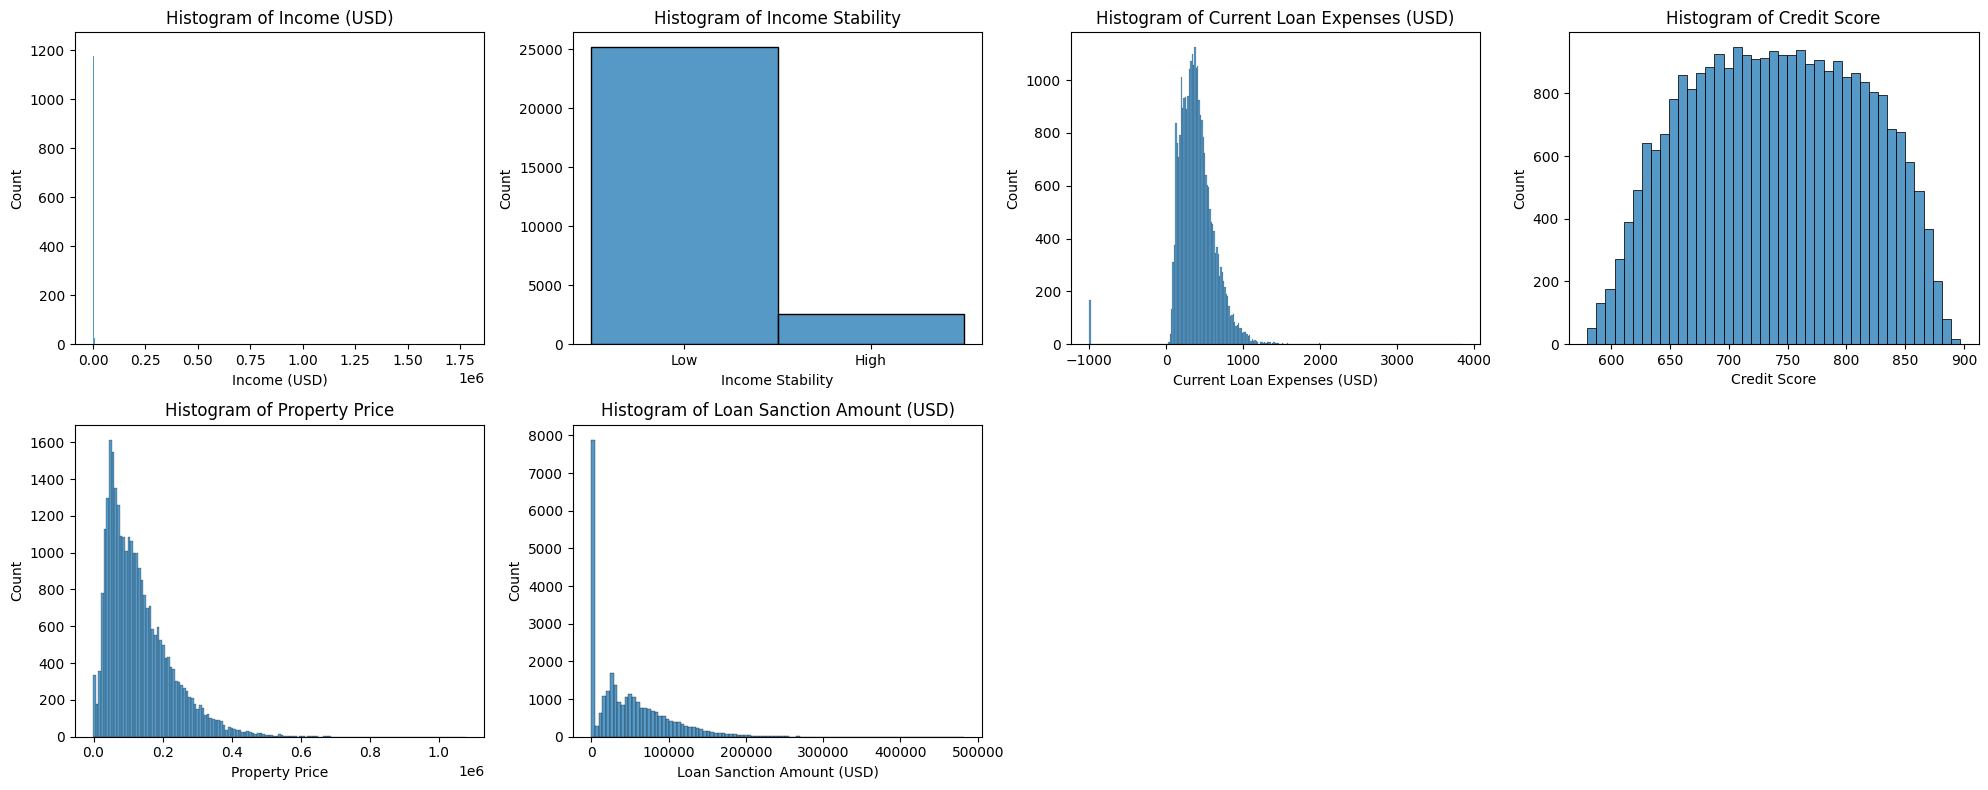

In [102]:
n = len(dataset.columns)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(dataset.columns):
    sns.histplot(data=dataset, x=column, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')

# Hide any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Filling NaN Values in feature Income (USD)**

In [103]:
dataset["Income (USD)"]=dataset["Income (USD)"].fillna(value=dataset["Income (USD)"].median(skipna=True))

**Filling NaN Values in feature Credit Score**

In [104]:
dataset["Credit Score"]=dataset["Credit Score"].fillna(value=dataset["Credit Score"].mean(skipna=True))

**Filling NaN Values in feature Income Stability**

In [105]:
dataset["Income Stability"]=dataset["Income Stability"].fillna(value=dataset["Income Stability"].mode()[0])

**Filling NaN values in feature Current Loan Expenses**

In [106]:
dataset["Current Loan Expenses (USD)"]=dataset["Current Loan Expenses (USD)"].fillna(value=dataset["Current Loan Expenses (USD)"].mean(skipna=True))

In [107]:
dataset["Income Stability"].unique()

array(['Low', 'High'], dtype=object)

#### **Encoding**

**Encoding Income Stability**

In [108]:
dataset["Income Stability"]=LabelEncoder().fit_transform(dataset["Income Stability"])

In [109]:
dataset["Income Stability"].unique()

array([1, 0])

#### **Outlier Analysis**

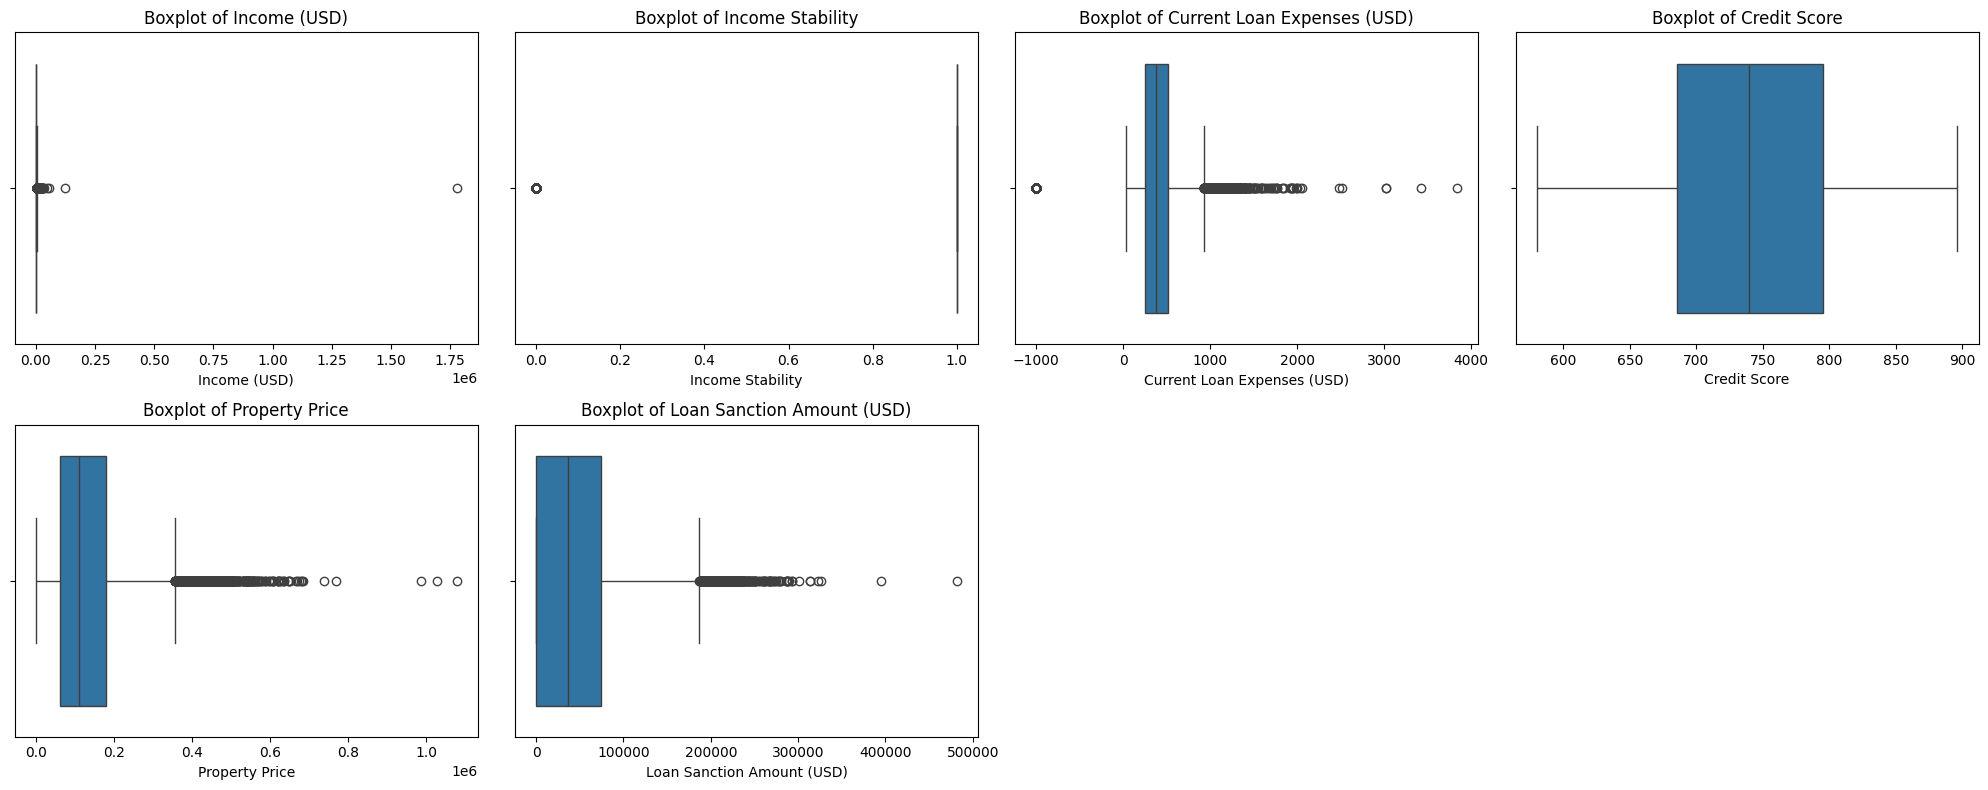

In [110]:
n = len(dataset.columns)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(dataset.columns):
    sns.boxplot(data=dataset, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

# Hide any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Clipping the feature Income (USD)**

In [111]:
lower = np.percentile(dataset["Income (USD)"],1) 
upper = np.percentile(dataset["Income (USD)"],99)

dataset["Income (USD)"] = np.clip(dataset["Income (USD)"], lower, upper)

**Clipping the feature Current Loan Expenses (USD)**

In [112]:
lower = np.percentile(dataset["Current Loan Expenses (USD)"],1) 
upper = np.percentile(dataset["Current Loan Expenses (USD)"],99)

dataset["Current Loan Expenses (USD)"] = np.clip(dataset["Current Loan Expenses (USD)"], lower, upper)

**Clipping the feature Property Price**

In [113]:
lower = np.percentile(dataset["Property Price"],1) 
upper = np.percentile(dataset["Property Price"],99)

dataset["Property Price"] = np.clip(dataset["Property Price"], lower, upper)

#### **Standardization/Normalization**

**Log one transformation**

In [114]:
dataset["Income (USD)"]= np.log1p(dataset["Income (USD)"])
dataset["Current Loan Expenses (USD)"]= np.log1p(dataset["Current Loan Expenses (USD)"])
dataset["Property Price"]= np.log1p(dataset["Property Price"])

/home/nikhil/system-wide-env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [115]:
dataset["Current Loan Expenses (USD)"]=dataset["Current Loan Expenses (USD)"].fillna(value=0)
dataset["Property Price"]= np.log1p(dataset["Property Price"]).fillna(value=0)
dataset["Loan Sanction Amount (USD)"]= np.log1p(dataset["Loan Sanction Amount (USD)"]).fillna(value=0)

**Z-Score Normalization**

In [116]:
dataset["Credit Score"]=StandardScaler().fit_transform(dataset[["Credit Score"]])

**Visulaization**

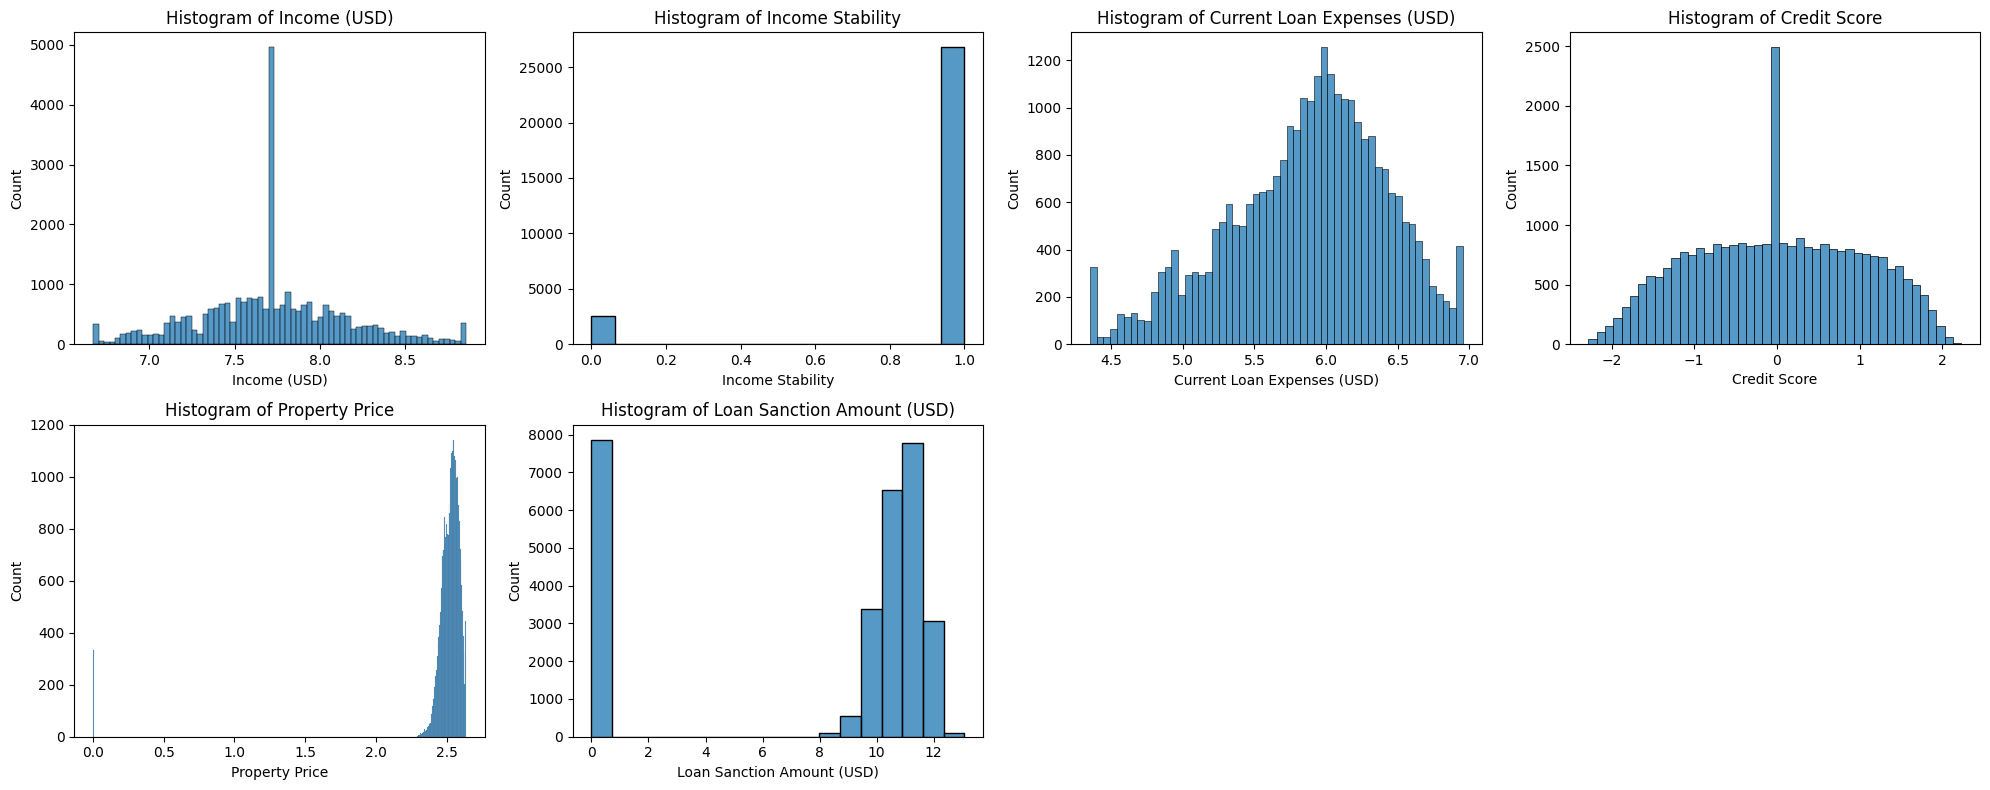

In [117]:
n = len(dataset.columns)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(dataset.columns):
    sns.histplot(data=dataset, x=column, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')

# Hide any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### **Splitting the Dataset**

In [118]:
X= dataset.drop(columns=["Loan Sanction Amount (USD)"])
y= dataset["Loan Sanction Amount (USD)"]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1429, random_state=42)

### **Model**

In [134]:
model=SVR(kernel='linear', C=100, gamma=0.1, epsilon=.1)
model.fit(X_train, y_train)

,kernel,'linear'
,degree,3
,gamma,0.1
,coef0,0.0
,tol,0.001
,C,100
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [ ]:
param_grid = {
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.1, 0.5],
    'svr__kernel': ['linear', 'rbf'],
    'svr__gamma': ['scale', 0.1]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # this ensures validation is only on X_val
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_val, y_val)

### **Performance Analysis**

**Training Metrics**

In [127]:
y_pred_train = np.expm1(model.predict(X_train))
y_train=np.expm1(y_train)

n = X_train.shape[0]
p = X_train.shape[1]

r2=r2_score(y_train, y_pred_train)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("R2-Score: ", r2)
print("Adjusted R2-Score: ",adj_r2)
print("Mean Squared Error: ", mean_squared_error(y_train, y_pred_train))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Mean Absolute Error: ", mean_absolute_error(y_train, y_pred_train))

R2-Score:  0.3538387892866297
Adjusted R2-Score:  0.3536550641769586
Mean Squared Error:  1513554096.1132684
Root Mean Squared Error:  38904.42257781586
Mean Absolute Error:  27999.800715457695


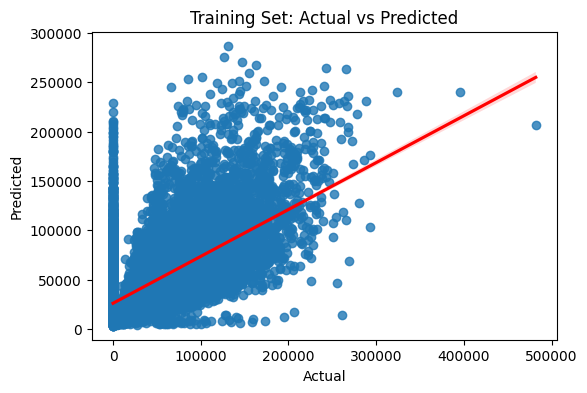

In [128]:
plt.figure(figsize=(6, 4))
sns.regplot(x=y_train, y=y_pred_train, line_kws={'color': 'red'})
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

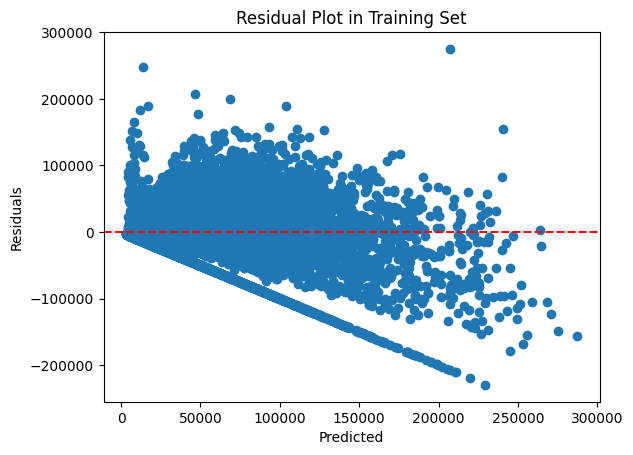

In [129]:
residuals = y_train - y_pred_train
plt.scatter(y_pred_train, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot in Training Set')
plt.show()


**Testing Metrics**

In [130]:
y_pred = np.expm1(model.predict(X_test))
y_test=np.expm1(y_test)

n = X_train.shape[0]
p = X_train.shape[1]

r2=r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("R2-Score: ", r2)
print("Adjusted R2-Score: ",adj_r2)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))

R2-Score:  0.3592453322823852
Adjusted R2-Score:  0.35906314443259335
Mean Squared Error:  1458581295.4935906
Root Mean Squared Error:  38191.37724007332
Mean Absolute Error:  27812.999296772585


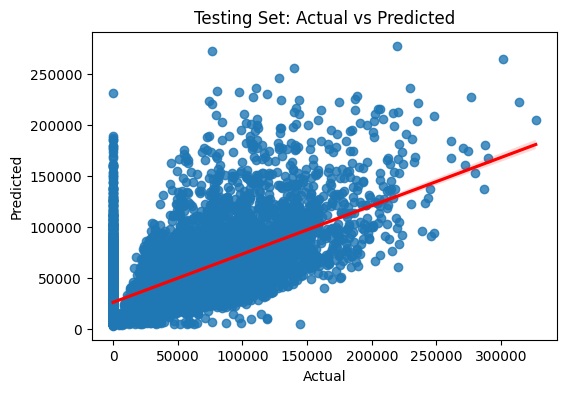

In [131]:
plt.figure(figsize=(6, 4))
sns.regplot(x=y_test, y=y_pred, line_kws={'color': 'red'})
plt.title("Testing Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

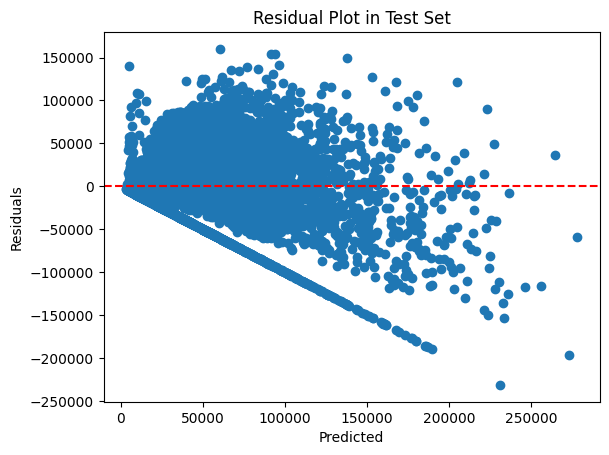

In [132]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot in Test Set')
plt.show()
